In [1]:
import json
import os
import time
from VIPurPCAvsMC import *
from utils import *
import jax.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA as pca_sklearn
from sklearn.datasets import load_iris, fetch_lfw_people

def cvp(jvp_fun, vjp_fun, X_flat, X_unflattener, C_flat, n, p, p_keep, i):
    v1 = np.ravel(jax.nn.one_hot(np.array([i]), min(n, p_keep)*p))
    v2 = vjp_fun(v1)[0]
    v3 = np.multiply(v2, C_flat)
    v4 = jvp_fun(v3)
    return v4

def expectation_maximization(Y, n, p, n_samples):
    M = np.mean(Y, axis=0)
    print(M.shape)
    Y = Y - M
    V_0 = np.identity(p)
    U_0 = np.identity(n)
    U_prev = U_0
    V_prev = V_0
    for i in range(1000):
        U_curr = 1/(n_samples*p)*np.sum(vmap(lambda y: np.dot(np.dot(y, np.linalg.inv(V_prev)), y.T))(Y), axis=0)
        V_curr = 1/(n_samples*n)*np.sum(vmap(lambda y: np.dot(np.dot(y.T, np.linalg.inv(U_prev)), y))(Y), axis=0)
        U_curr = U_curr/np.linalg.norm(U_curr, 2)
        V_curr = np.linalg.norm(U_curr, 2)*V_curr
        U_prev = U_curr
        V_prev = V_curr
        if i%100==0:
            print(V_prev)
    return U_curr, V_curr

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


In [16]:
print(target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [9]:
X = X - np.mean(X, axis=0)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
#A = np.load('../data/macrophage/A.npy')
#B = np.load('../data/macrophage/B.npy')
#A = A + 1e-3*np.eye(A.shape[0])
#B = B + 1e-3*np.eye(B.shape[0])
C = np.ones(X.shape[0]*X.shape[1])
C = np.maximum(C, 1e-6)
C_flat, C_unflattener = flatten_util.ravel_pytree(C)

In [10]:
p_keep=2
n, p = X.shape
start = time.time()
print('Start PCA')
V = pca(X_flat, X_unflattener, p_keep)
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, C_flat, n, p, p_keep, s)
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C_output = np.vstack([vmap(cvp_fun)(i) for i in b])
end = time.time()
print(end-start)

Start PCA
503.9303958415985


In [11]:
n_iter = 100
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C_output+1e-5*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([X @ np.transpose(np.reshape(i, (min(n, p_keep), p), 'C')) for i in V_drawn])

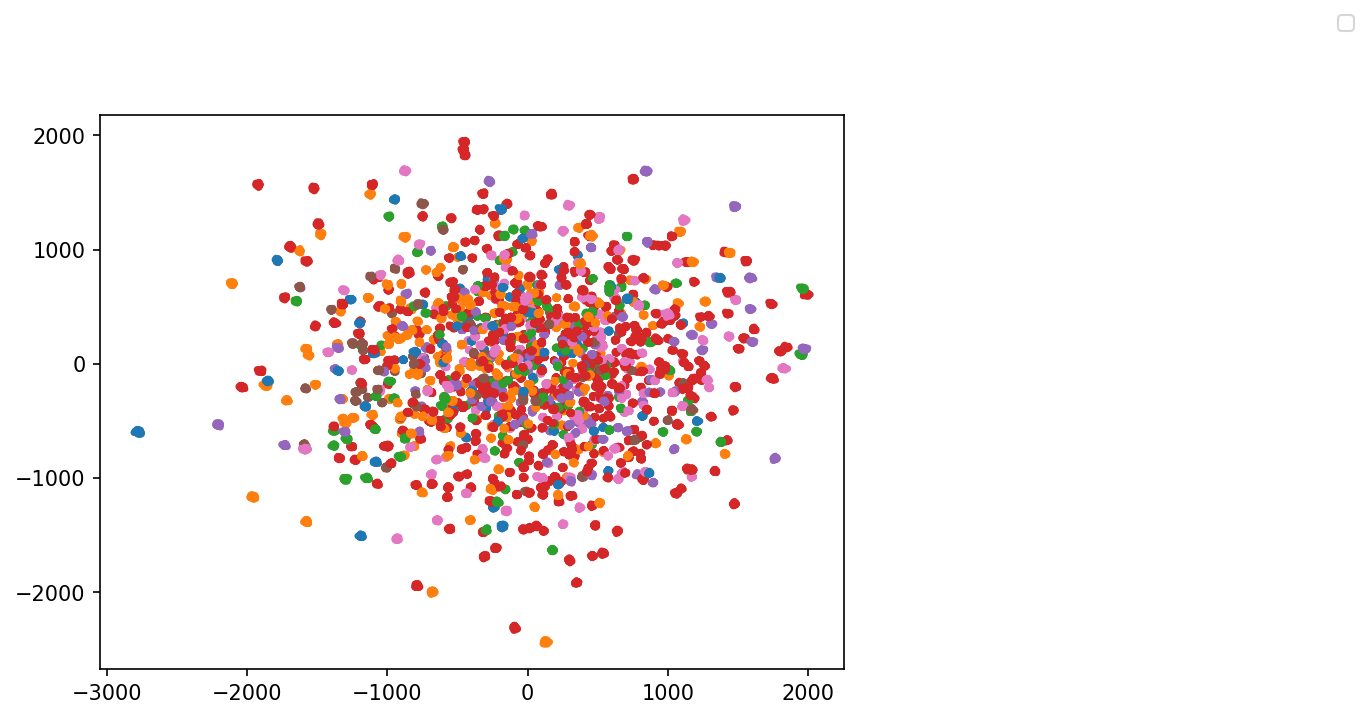

In [15]:
f, ax1 = plt.subplots(1)
pcx, pcy = (0, 1)
for j in range(n):
    ax1.scatter(x=T_s[:, j, pcx], y=T_s[:, j, pcy], s=5, c=['C'+str(y[j]) for i in range(n_iter)])#, label=target_names[j], c=['C'+str(y[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    #ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)
ax1.legend(loc='upper right', bbox_to_anchor=(1.7, 1.2), ncol=2)

In [21]:
X

DeviceArray([[161.61543  , 156.26424  , 144.08127  , ..., -33.623707 ,
              -24.674175 , -18.60326  ],
             [-53.717907 , -47.0691   , -60.918736 , ...,  -2.9570417,
                1.6591613,  27.39674  ],
             [ -3.051244 ,   5.930898 ,  18.414598 , ...,  54.70962  ,
               69.99249  ,  77.06341  ],
             ...,
             [ -6.0512443, -17.735765 , -33.5854   , ..., -76.290375 ,
              -63.34084  , -60.936592 ],
             [-42.05124  , -32.40243  , -19.585402 , ...,  76.04297  ,
               65.325836 ,  60.06341  ],
             [-62.717907 , -70.73576  , -74.91874  , ..., -85.6237   ,
              -77.67417  , -44.60326  ]], dtype=float32)

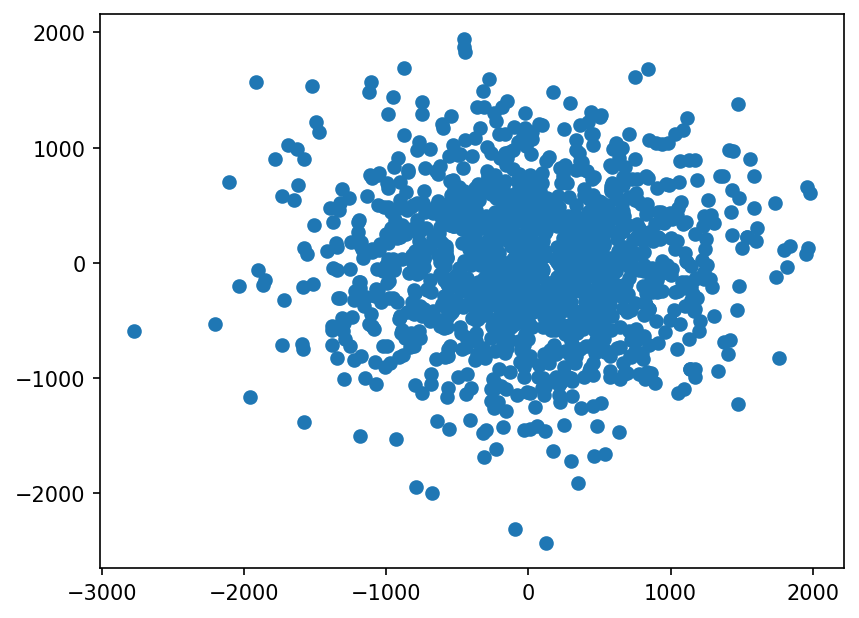

In [20]:
T = X @ np.transpose(np.reshape(V, (min(n, p_keep), p), 'C'))
plt.scatter(T[:, 0], T[:, 1])